In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import numpy as np
import os
import datetime

In [2]:
data_path = 'data/'
mnist = datasets.MNIST(data_path, train=True, download=False,
                       transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

mnist_val = datasets.MNIST(data_path, train=False, download=False,
                           transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
)

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available() else
          torch.device('cpu'))

print('Train on {}'.format(device))

Train on cuda


In [4]:
# imgs = torch.stack([img_t for img_t, _ in mnist], dim=3)

In [5]:
# imgs.view(3, -1).mean(dim=1)

In [6]:
# imgs.view(3, -1).std(dim=1)

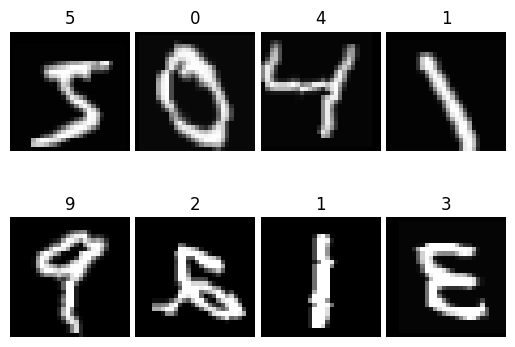

In [7]:
for i in range(8):
    img, label = mnist[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.show()

In [8]:
img_t, _  = mnist[120]

In [9]:
img_t.shape

torch.Size([1, 28, 28])

In [10]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(1, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(7*7*n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 7 * 7 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
def training_loop(n_epochs, model, optimizer, scheduler, loss_fn, train_loader):
    model.train()
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss = loss_fn(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train+=loss.item()
        
        #scheduler.step()

        if epoch == 1 or epoch % 10 == 0:
           print("{} Epoch {}, Training Loss {}".format(
              datetime.datetime.now(), epoch,
              loss_train / len(train_loader)
           ))


In [13]:
model = NetDropout().to(device=device)
train_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)
optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=50,
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-11-29 11:45:00.339072 Epoch 1, Training Loss 1.023370855271435
2023-11-29 11:59:36.014204 Epoch 10, Training Loss 0.22775611196007176
2023-11-29 12:16:06.115414 Epoch 20, Training Loss 0.18725428047643572
2023-11-29 12:33:17.097392 Epoch 30, Training Loss 0.17359266496464007
2023-11-29 12:51:13.275545 Epoch 40, Training Loss 0.16666536326252068
2023-11-29 13:08:03.343727 Epoch 50, Training Loss 0.15613974080180754


In [14]:
torch.save(model.state_dict(), "weights/" + 'Model_50.pt')

In [6]:
# model_state = torch.load('weights/mnist_dropout.pt', map_location = torch.device('cuda'))

In [7]:
# model = NetDropout().to(device=device)
# model.load_state_dict(model_state)

<All keys matched successfully>

In [15]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

In [16]:
def validate(model, train_loader, val_loader):
    model.eval()
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

            print("Accuracy {}: {:.2f}".format(name, correct / total))

In [17]:
validate(model=model, train_loader=train_loader, val_loader=val_loader)

Accuracy train: 0.97
Accuracy val: 0.97


In [26]:
test_path = 'test/'

In [18]:
img = Image.open('image/number.png')
#img = np.clip(img, 0, 255)

In [19]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [20]:
transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [21]:
tensor_img = transformer(img)

In [22]:
tensor_img.shape

torch.Size([1, 28, 28])

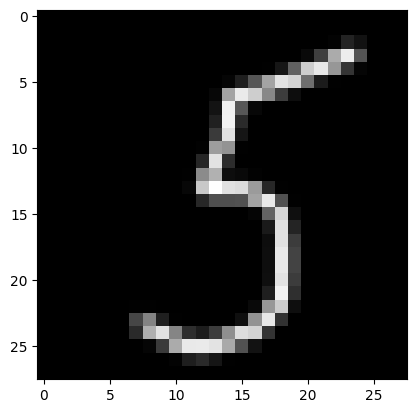

In [23]:
#tensor_img = tensor_img.unsqueeze(0)
plt.imshow(tensor_img.permute(1, 2, 0), cmap='gray')
plt.show()

In [24]:
with torch.no_grad():
     tensor_img = tensor_img.to(device=device)
     out = model(tensor_img.unsqueeze(0))
     _, pred = torch.max(out, 1)
     proba = F.softmax(out, dim=1)[0, pred].item() * 100
     
print(pred)
print(proba)

tensor([5], device='cuda:0')
99.40243363380432


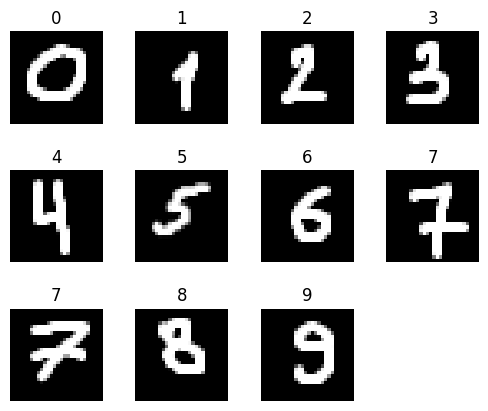

In [27]:
accuracy_test = 0.0

transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

labels = [int(filename[0]) for filename in os.listdir(test_path)]

for index, filename in enumerate(os.listdir(test_path)):

    img = Image.open(test_path+filename)
    img_t = transformer(img)
    img_t = img_t.unsqueeze(0)

    with torch.no_grad():
         img_t = img_t.to(device=device)
         out = model(img_t)
         
         _, predict_label = torch.max(out, 1)

    if predict_label.item() == labels[index]:
       accuracy_test += 1.0

    plt.subplot(3, 4, index+1)
    plt.imshow(img, cmap='gray')
    plt.title(predict_label.item())
    plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.show()

In [28]:
print(f"{accuracy_test / len(labels)}")

1.0
